In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

In [12]:
data = pd.read_csv("Churn_Modelling.csv",index_col=0)
data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


<Axes: xlabel='Exited', ylabel='count'>

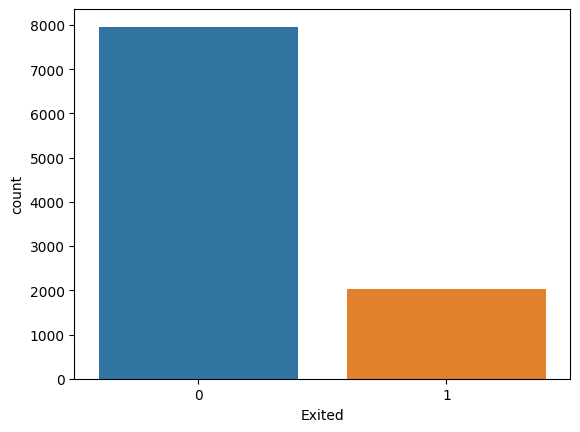

In [13]:
sns.countplot(x='Exited', data=data)
## Clearly the dataset is imbalanced, Selection of proper evaluation metrics would help to counter this.
## Recall would be much better option as it penalises false negative.

<Axes: xlabel='Gender', ylabel='count'>

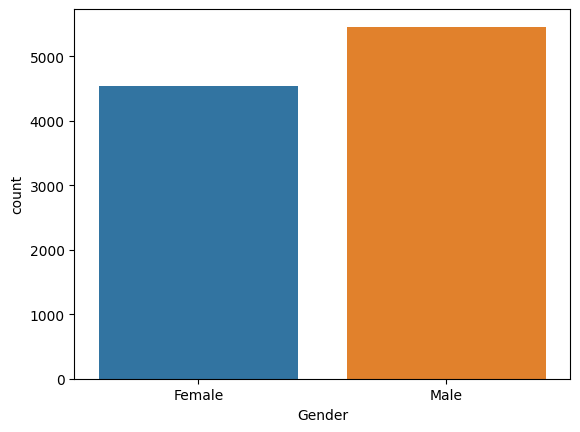

In [14]:
sns.countplot(x='Gender', data=data)
## A workable distribution

In [15]:
#Converting data into categorical data
data['Geography']=data['Geography'].astype('category')
data['Gender']=data['Gender'].astype('category')
data.drop(['Surname','CustomerId'],axis=1,inplace=True)

data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [16]:
from sklearn.model_selection import train_test_split
X = data.drop(['Exited'], axis=1)
y = data['Exited']

categorical_features=['Geography', 'Gender','HasCrCard', 'IsActiveMember']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.15, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.20, stratify=y)
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

train_pool=Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_pool=Pool(data=X_val, label=y_val, cat_features=categorical_features)
test_pool=Pool(data=X_test, label=y_test, cat_features=categorical_features)

model= CatBoostClassifier(class_weights=class_weights)
model.fit(train_pool,eval_set=val_pool, verbose=100)

Learning rate set to 0.052963
0:	learn: 0.6685924	test: 0.6705435	best: 0.6705435 (0)	total: 24.4ms	remaining: 24.4s
100:	learn: 0.4149547	test: 0.4731315	best: 0.4730958 (99)	total: 2.78s	remaining: 24.7s
200:	learn: 0.3787189	test: 0.4768261	best: 0.4725444 (143)	total: 5.44s	remaining: 21.6s
300:	learn: 0.3404805	test: 0.4864487	best: 0.4725444 (143)	total: 8.19s	remaining: 19s
400:	learn: 0.3096132	test: 0.4979532	best: 0.4725444 (143)	total: 10.9s	remaining: 16.3s
500:	learn: 0.2845619	test: 0.5095694	best: 0.4725444 (143)	total: 13.6s	remaining: 13.6s
600:	learn: 0.2625603	test: 0.5214678	best: 0.4725444 (143)	total: 16.4s	remaining: 10.9s
700:	learn: 0.2434521	test: 0.5324074	best: 0.4725444 (143)	total: 19s	remaining: 8.12s
800:	learn: 0.2269542	test: 0.5414726	best: 0.4725444 (143)	total: 21.7s	remaining: 5.4s
900:	learn: 0.2123502	test: 0.5505347	best: 0.4725444 (143)	total: 24.5s	remaining: 2.69s
999:	learn: 0.1981241	test: 0.5583686	best: 0.4725444 (143)	total: 27.2s	remain

In [17]:
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, y_pred)
cm

array([[1004,  190],
       [  71,  235]], dtype=int64)

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      1194
           1       0.55      0.77      0.64       306

    accuracy                           0.83      1500
   macro avg       0.74      0.80      0.76      1500
weighted avg       0.86      0.83      0.84      1500



- The recall for the exiting calss is 0.79

### Feture Importance

<BarContainer object of 10 artists>

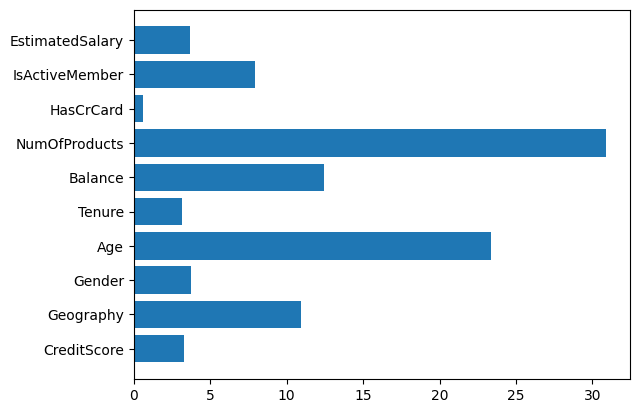

In [19]:
plt.barh(X.columns,model.get_feature_importance())

#### From the plot it is evident that the top three important feature determining weather the customer will exit the bank or not is
- Number  of Products
- Age
- Balance